<a href="https://colab.research.google.com/github/wajeehulhassan0051/Deep-learning-lab/blob/main/OEL0051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install packages
!pip install -q kaggle tensorflow-addons
# Step 2: Set up Kaggle API
from google.colab import files
import os

if not os.path.exists('/root/.kaggle/kaggle.json'):
    uploaded = files.upload()
    kaggle_file = list(uploaded.keys())[0]
    !mkdir -p ~/.kaggle
    !cp "{kaggle_file}" ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download dataset with error handling
if not os.path.exists('/content/flowers'):
    !kaggle datasets download -d alxmamaev/flowers-recognition --force
    !unzip -q flowers-recognition.zip
else:
    print("Using existing dataset files")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 54% 122M/225M [00:00<00:00, 1.26GB/s]
100% 225M/225M [00:00<00:00, 765MB/s] 


In [ ]:
# Step 4: Clean dataset organization
import shutil
from sklearn.model_selection import train_test_split

# Clear previous organization if exists
!rm -rf /content/flower_data

# Create fresh directory structure
!mkdir -p /content/flower_data/{train,val,test}
flower_classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

for cls in flower_classes:
    !mkdir -p /content/flower_data/train/{cls}
    !mkdir -p /content/flower_data/val/{cls}
    !mkdir -p /content/flower_data/test/{cls}

    src_dir = f'/content/flowers/{cls}'
    files = [f for f in os.listdir(src_dir) if f.endswith('.jpg')]

    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    def copy_files(files, dest):
        for f in files:
            shutil.copy(os.path.join(src_dir, f), os.path.join(dest, f))

    copy_files(train_files, f'/content/flower_data/train/{cls}')
    copy_files(val_files, f'/content/flower_data/val/{cls}')
    copy_files(test_files, f'/content/flower_data/test/{cls}')

print("Dataset organization complete!")

Dataset organization complete!


In [ ]:
# Step 5: Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# Step 6: Set parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 15
INIT_LR = 1e-4
NUM_CLASSES = 5

In [ ]:
# Step 7: Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/flower_data/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/flower_data/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/flower_data/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3019 images belonging to 5 classes.
Found 649 images belonging to 5 classes.
Found 649 images belonging to 5 classes.


In [ ]:
# Step 8: Model building function with fixed architecture
def build_mobilenetv2():
    # Create base model with fixed parameters
    base_model = MobileNetV2(
        input_shape=(160, 160, 3),
        include_top=False,
        weights='imagenet',
        alpha=1.0  # This is crucial for consistent architecture
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build complete model
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model, base_model

In [ ]:
# Step 9: Initial training
model, base_model = build_mobilenetv2()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Custom ModelCheckpoint that saves only weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'initial_weights.weights.h5', # Changed filepath to end with .weights.h5
    save_weights_only=True,  # This is crucial
    save_best_only=True,
    monitor='val_accuracy'
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 45s 364ms/step - accuracy: 0.2992 - loss: 1.8786 - val_accuracy: 0.4684 - val_loss: 1.2889
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.4518 - loss: 1.3647 - val_accuracy: 0.6256 - val_loss: 1.0131
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.5663 - loss: 1.0964 - val_accuracy: 0.7011 - val_loss: 0.8629
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step - accuracy: 0.6340 - loss: 0.9914 - val_accuracy: 0.7319 - val_loss: 0.7696
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.6902 - loss: 0.8342 - val_accuracy: 0.7504 - val_loss: 0.7034
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.7121 - loss: 0.7653 - val_accuracy: 0.7612 - val_loss: 0.6626
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.7360 - loss: 0.7296 - val_accuracy: 0.7704 - val_loss: 0.6249
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 257ms/step - accuracy: 0.7520 - loss: 0.6797 - val_accu

In [ ]:
# Step 10: Fine-tuning
# Rebuild model to ensure consistent architecture
model, base_model = build_mobilenetv2()

# Load initial weights
# Corrected filename to match the saved file in Step 9
model.load_weights('initial_weights.weights.h5')

# Unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save only weights during fine-tuning
fine_tune_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fine_tuned_weights.weights.h5',  # Changed filepath to end with .weights.h5
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy'
)

history_fine = model.fit(
    train_generator,
    epochs=EPOCHS+5,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[fine_tune_checkpoint]
)

Epoch 15/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 57s 388ms/step - accuracy: 0.7181 - loss: 0.7653 - val_accuracy: 0.8351 - val_loss: 0.4694
Epoch 16/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.7773 - loss: 0.6058 - val_accuracy: 0.8459 - val_loss: 0.4571
Epoch 17/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.8065 - loss: 0.5419 - val_accuracy: 0.8428 - val_loss: 0.4326
Epoch 18/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.8139 - loss: 0.4843 - val_accuracy: 0.8552 - val_loss: 0.4170
Epoch 19/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.8583 - loss: 0.4140 - val_accuracy: 0.8598 - val_loss: 0.4069
Epoch 20/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.8563 - loss: 0.4101 - val_accuracy: 0.8629 - val_loss: 0.3942


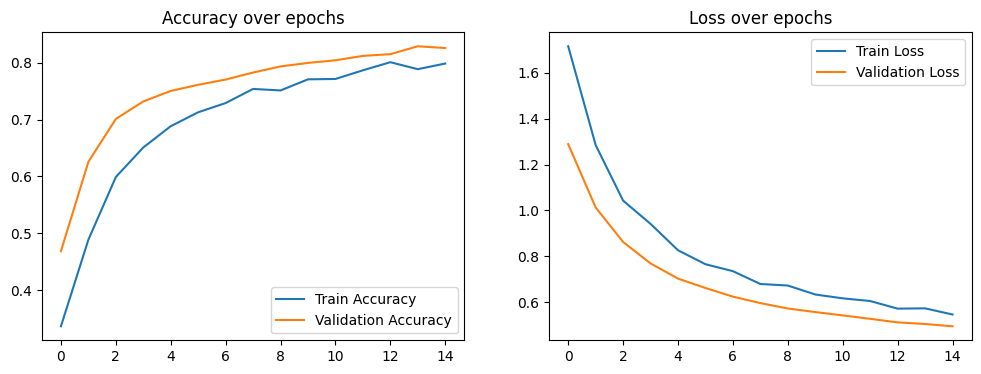

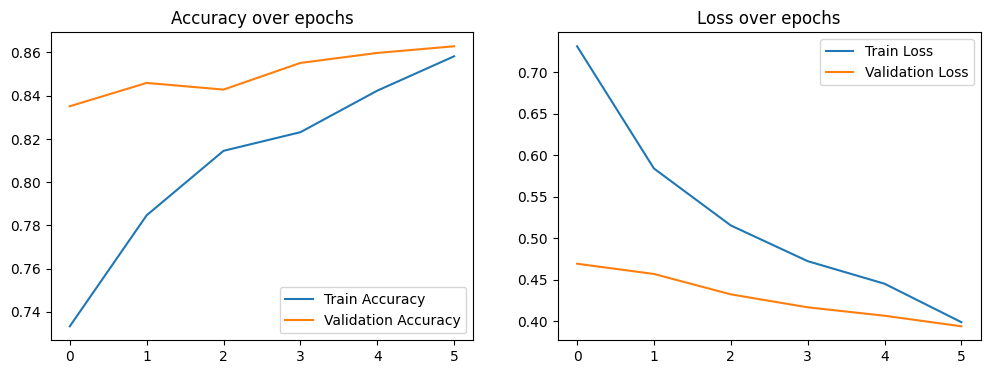

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


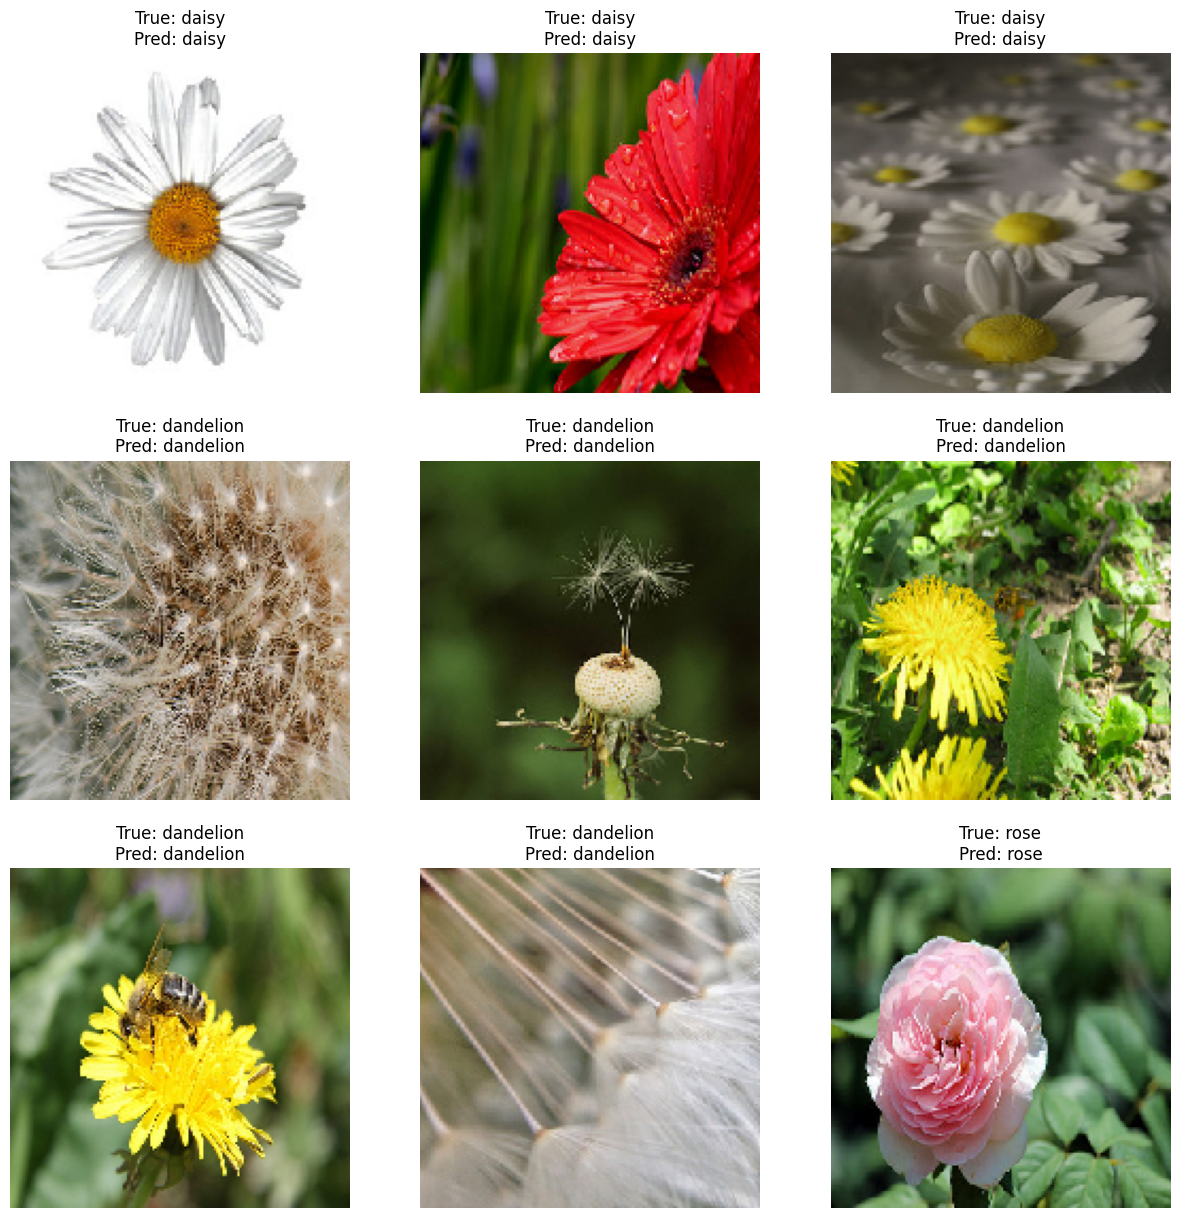

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.show()

plot_history(history)
if 'history_fine' in locals():
    plot_history(history_fine)

# Display some predictions
plt.figure(figsize=(15, 15))
# Use iter() to create an iterator from the generator
test_iter = iter(test_generator)

# Import numpy if not already imported
import numpy as np
# Import os if not already imported
import os

# Define the list of class names based on the dataset directory structure
# flow_from_directory assigns class indices alphabetically by default
class_names = sorted(os.listdir('/content/flower_data/test'))


for i in range(9):
    plt.subplot(3, 3, i+1)
    # Use next() to get the next batch
    img, label = next(test_iter)
    # Since we're getting a batch, predict on the first image in the batch
    pred_label = class_names[np.argmax(model.predict(img[0:1]))]
    # The label is one-hot encoded for the batch, so get the true label for the first image
    true_label = class_names[np.argmax(label[0])]

    plt.imshow(img[0])
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()